In [14]:
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import os
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
!pip install timm
from timm.models import create_model
import pickle
import random
import copy
import matplotlib.patches as patches
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
!pip install torchattacks
import torchattacks
from torchattacks.attack import Attack
from torchattacks.attacks._differential_evolution import differential_evolution

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 25.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/MLHC/

Mounted at /content/drive/
/content/drive/My Drive/MLHC


In [3]:
datadir = '../MLHC/chest_xray/chest_xray'
traindir = datadir + '/train/'
validdir = datadir + '/val/'
testdir = datadir + '/test/'


# Change to fit hardware
batch_size = 32

# Whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [4]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=1, shuffle=True)
}

In [6]:
device = "cuda:0"
m = nn.Sigmoid()

In [8]:
model = create_model('deit_tiny_distilled_patch16_224', pretrained=True)
model.head_dist = nn.Linear(192, 1)
model.head = nn.Linear(192, 1)
model = model.train()
model = model.to(device)
vit = model

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_distilled_patch16_224-b40b3cf7.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_distilled_patch16_224-b40b3cf7.pth


In [9]:
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.Adam(vit.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

In [10]:
sum(p.numel() for p in vit.parameters() if p.requires_grad)

5525186

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vit(inputs)
        loss = criterion(m(outputs).reshape(-1), labels)
        loss.backward()
        optimizer.step()

print('Finished Training')

In [13]:
# pickle.dump(vit, open('vit_MLHC.pkl', 'wb'))

In [15]:
vit = pickle.load(open("vit_MLHC.pkl", 'rb')).to(device)

In [16]:
def show_img(img, x1, y1, x_b, y_b):
    fig, ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((y1, x1), 1, 1, linewidth=10, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((y_b, x_b), 1, 1, linewidth=10, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    rect = patches.Rectangle((10, 10), 1, 1, linewidth=10, edgecolor='pink', facecolor='none')
    ax.add_patch(rect)
    fig.set_size_inches(4, 4)
    plt.axis('off')
    plt.show()
    plt.close()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(4, 4))
    plt.imshow(img1)
    plt.imshow(img2[:,:,0], alpha=alpha)
    plt.axis('off')
    plt.show()
    plt.close()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

def visualsize_attn(x, model, x_b, y_b):
  x = x[0].to(device)
  model = vit
  model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

  y = model(x.unsqueeze(0))
  attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
  cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

  img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
  cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
  x1 = (cls_resized[:,:,0]==torch.max(cls_resized[:,:,0])).nonzero()[0][0]
  y1 = (cls_resized[:,:,0]==torch.max(cls_resized[:,:,0])).nonzero()[0][1]
  show_img(torch.permute(x, (1, 2, 0)).cpu(), x1.item(), y1.item(), x_b, y_b)
  show_img2(img_resized.cpu(), cls_resized.cpu(), alpha=0.8)
  return x1, y1


In [17]:

class OnePixel_(Attack):

    def __init__(self, model, pixels=1, steps=75, popsize=400, inf_batch=128):
        super().__init__("OnePixel_", model)
        self.pixels = pixels
        self.steps = steps
        self.popsize = popsize
        self.inf_batch = inf_batch
        self._supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self._targeted:
            target_labels = self._get_target_label(images, labels)

        batch_size, channel, height, width = images.shape

        bounds = [(0, height), (0, width)]+[(-2.11790393, 2.2489083), (-2.03571429, 2.42857143), (-1.80444444, 2.64)] 
          
        bounds = bounds*self.pixels

        popmul = max(1, int(self.popsize/len(bounds)))

        adv_images = []
        for idx in range(batch_size):
            image, label = images[idx:idx+1], labels[idx:idx+1]

            if self._targeted:
                target_label = target_labels[idx:idx+1]

                def func(delta):
                    return self._loss(image, target_label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, target_label, delta)

            else:
                def func(delta):
                    return self._loss(image, label, delta)

                def callback(delta, convergence):
                    return self._attack_success(image, label, delta)

            delta = differential_evolution(func=func,
                                           bounds=bounds,
                                           callback=callback,
                                           maxiter=self.steps, popsize=popmul,
                                           init='random',
                                           recombination=1, atol=-1,
                                           polish=False).x
            delta = np.split(delta, len(delta)/len(bounds))
            adv_image = self._perturb(image, delta)
            adv_images.append(adv_image)

        adv_images = torch.cat(adv_images)
        return adv_images


    def _loss(self, image, label, delta):
        adv_images = self._perturb(image, delta)  # Mutiple delta
        prob = self._get_prob(adv_images)
        if label.item() == 1:
            return prob
        else:
            return 1 - prob

    def _attack_success(self, image, label, delta):
        adv_image = self._perturb(image, delta)  # Single delta
        prob = self._get_prob(adv_image)
        if (prob[0][0] <= 0.5 and label.item() == 0) or (prob[0][0] > 0.5 and label.item() == 1):
            return False
        return True

    def _get_prob(self, images):
        with torch.no_grad():
            batches = torch.split(images, self.inf_batch)
            outs = []
            for batch in batches:
                out = self.model(batch)
                outs.append(out)
        outs = torch.cat(outs)
        # prob = F.softmax(outs, dim=1)
        prob = m(outs)
        return prob.detach().cpu().numpy()

    def _perturb(self, image, delta):
        delta = np.array(delta)
        if len(delta.shape) < 2:
            delta = np.array([delta])
        num_delta = len(delta)
        adv_image = image.clone().detach().to(self.device)
        adv_images = torch.cat([adv_image]*num_delta, dim=0)
        for idx in range(num_delta):
            pixel_info = delta[idx].reshape(self.pixels, -1)
            for pixel in pixel_info:
                pos_x, pos_y = pixel[:2]
                channel_v = pixel[2:]
                for channel, v in enumerate(channel_v):
                    adv_images[idx, channel, int(pos_x), int(pos_y)] = v
        return adv_images

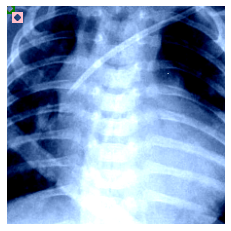

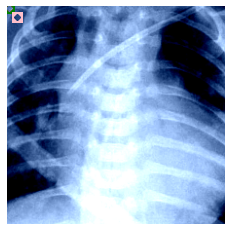

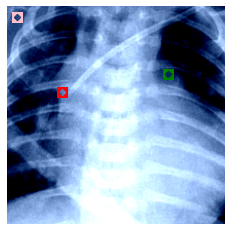

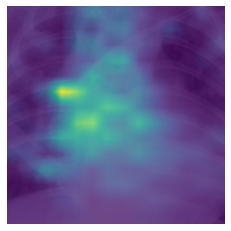

KeyboardInterrupt: ignored

In [18]:
vit = vit.eval()
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if labels == 0:
          continue
        outputs = vit(images)
        if (m(outputs).item() <= 0.5 and labels.item() == 0) or (m(outputs).item() > 0.5 and labels.item() == 1):
            new_model = vit
            my_attack = OnePixel_(new_model, pixels=1, steps=75, popsize=400, inf_batch=128)
            adv_images = my_attack(images, labels)
            show_img(torch.permute(adv_images[0], (1, 2, 0)).cpu(), 1, 1, 1, 1)
            show_img(torch.permute(images[0], (1, 2, 0)).cpu(), 1, 1, 1, 1)
            outputs = new_model(adv_images)
            x_b = (torch.nonzero(adv_images-images)[0][2]).item()
            y_b = (torch.nonzero(adv_images-images)[0][3]).item()          
            x_a, y_a = visualsize_attn(images, new_model, x_b, y_b)
            x_c , y_c = random.randint(0, 223), random.randint(0, 223)